In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))   

Author: Andrew Tarzia

Date Created: 12 Jul 2018

License:

# Notebook for getting molecule parameters using RDKIT


In [3]:
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors3D import NPR1, NPR2, PMI1, PMI2, PMI3
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Geometry import rdGeometry
from rdkit.Chem import PyMol
from rdkit import Geometry
import tempfile
import matplotlib.pyplot as plt

# Notes:
# Todo:
- timing
 - speed up reading: https://rdkit.blogspot.com/2016/09/avoiding-unnecessary-work-and.html

In [4]:
# molecule file dir
molecule_file = '/home/atarzia/psp/molecules/test_molecules.txt'
# output dir
output_dir = '/home/atarzia/psp/molecules/'

In [5]:
def read_mol_txt_file(filename):
    """Function to read molecule SMILES and information from txt file.
    
    """
    data = pd.read_table(filename, delimiter=':')
    molecules = {}
    diameters = {}
    for i, row in data.iterrows():
#         try:
#             name, smile, radius = line.rstrip().split(':')
#         except ValueError:
#             print(line, 'had : in there twice, fix this naming or SMILE')
#             print('skipped')
        name = row['molecule']
        smile = row['smile']
        diameter = row['diameter']
        molecules[name] = smile
        diameters[name] = diameter
    return data, molecules, diameters

In [6]:
def get_inertial_prop(mol, cids):
    """Get inertial 3D descriptors for all conformers in mol.
    
    """
    # ratio 1 is I1/I3
    # ratio 2 is I2/I3
    sml_PMI, mid_PMI, lge_PMI = [], [], []
    ratio_1_, ratio_2_ = [], []
    for cid in cids:
        sml_PMI.append(PMI1(mol, confId=cid))
        mid_PMI.append(PMI2(mol, confId=cid))
        lge_PMI.append(PMI3(mol, confId=cid))
        ratio_1_.append(NPR1(mol, confId=cid))
        ratio_2_.append(NPR2(mol, confId=cid))
    
    return sml_PMI, mid_PMI, lge_PMI, ratio_1_, ratio_2_

In [7]:
def produce_quick_fig_mol(molecules, filename):
    """Produce a quick/dirty figure showing all the 2D coordinates of molecules in the data set.
    
    """
    mols = [Chem.MolFromSmiles(x) for x in molecules.values()]
    for m in mols: tmp = Chem.Compute2DCoords(m)
    # Draw.MolToFile(mols[0], output_dir+'mol1.png')
    img=Draw.MolsToGridImage(mols,molsPerRow=10,subImgSize=(200,200),legends=[x for x in molecules.keys()])
    img.save(filename)

In [8]:
def get_COMs(mol):
    """Get COM of all conformers of mol.
    
    Code from: https://iwatobipen.wordpress.com/2016/08/16/scoring-3d-diversity-using-rdkit-rdkit/
    
    """
    coms = []
    numatoms = mol.GetNumAtoms()
    for confId in range(len(cids)):
        # print('conf:', confId)
        # print('number of atoms:', numatoms)
        conf = mol.GetConformer(confId)    
        coords =  np.array([list(conf.GetAtomPosition(atmidx)) for atmidx in range(numatoms)])
        # print('coords:')
        # print(coords)
        atoms = [atom for atom in mol.GetAtoms()]
        mass = Descriptors.MolWt(mol)
        # print('mass:', mass)
        centre_of_mass = np.array(np.sum(atoms[i].GetMass() * coords[i] for i in range(numatoms))) / mass
        # print(centre_of_mass)   
        coms.append(centre_of_mass)
    
    return coms

In [9]:
def show_all_conformers(viewer, mol, cids):
    """Show all conformers in a pymol viewer.
    
    Code from: http://nbviewer.jupyter.org/gist/greglandrum/4316435
    
    """
    viewer.DeleteAll()
    for cid in cids: 
        viewer.ShowMol(mol, confId=cid, name='Conf-%d'%cid, showOnly=False)

In [10]:
def show_shape(viewer, mol, cid, shape):
    """Show the encoded shape for a conformer (cid) of a molecule in viewer.
    
    """
    viewer.server.deleteAll()
    # write shape to file
    tmpFile = tempfile.mktemp('.grd') 
    Geometry.WriteGridToFile(shape, tmpFile)
    viewer.ShowMol(mol, name='testMol', showOnly=True, confId=cid)
    viewer.server.loadSurface(tmpFile, 'testGrid', '', 2.5)

In [11]:
def get_molec_shape(conf, confId, vdwScale=1.0, boxMargin=2.0, spacing=0.2):
    """Get the shape of a conformer of a molecule as a grid representation.
    
    """
    box = Chem.ComputeConfBox(conf)
    sideLen = (box[1].x-box[0].x + 2*boxMargin,
               box[1].y-box[0].y + 2*boxMargin,
               box[1].z-box[0].z + 2*boxMargin)
    shape = rdGeometry.UniformGrid3D(2*sideLen[0],
                                     2*sideLen[1],
                                     2*sideLen[2],
                                     spacing=spacing)
    Chem.EncodeShape(mol, shape, confId, ignoreHs=False, vdwScale=vdwScale)
    return sideLen, shape

In [12]:
def def_point(x, y, z):
    """Define a 3D point in RDKIT
    
    """
    point = rdGeometry.Point3D()
    point.x = x
    point.y = y
    point.z = z
    
    return point

In [13]:
def define_vector(axis, max_side_len):
    """Define vector to test shape values for.
    
    """
    vector_mag = np.arange(-max_side_len/2, max_side_len/2 + 0.1, 0.01)
    vectors = [i * axis for i in vector_mag]
    
    return vectors

In [14]:
def get_boundary_idx(values):
    """Get index of shape grid boundaries along axis.
    
    """
    for i in np.arange(len(values)):
        # get the index of the first non zero value
        if values[i] > 2:
            ind_1 = i
            break
    for i in np.arange(len(values)-1, -1, -1):
        # get the index of the last non zero value
        if values[i] > 2:
            ind_2 = i
            break
    return ind_1, ind_2

In [15]:
def get_dist_and_values(vectors, com_pt, shape):
    """
    
    """
    values = []
    distances = []
    for p in vectors:
        pt = def_point(*p)
        distances.append(pt.Distance(com_pt))
        values.append(shape.GetValPoint(pt))

    return values, distances

In [16]:
def get_vdw_diameters(mol, cids, mol_coms, vdwScale=1.0, boxMargin=2.0,
                      spacing=0.2, show=False):
    """Get the extent of the VDW size of each conformer along its principle axes.
    
    
    """
    # over conformers
    conf_diameters = []
    conf_axes = []
    conf_moments = []
    for confId in cids:
        conf = mol.GetConformer(confId)
        # try:
        #     Chem.CanonicalizeConformer(conf)
        # except RuntimeError:
        #     pass
        sideLen, shape = get_molec_shape(conf, confId, vdwScale=vdwScale, 
                                         boxMargin=boxMargin,
                                         spacing=spacing)
        if show is True:
            show_shape(v, mol, confId, shape)

        # get extent of shape along principle axes
        axes, moments = Chem.ComputePrincipalAxesAndMoments(conf, ignoreHs=False)
        conf_axes.append(axes)
        conf_moments.append(moments)
        sml_PMI, mid_PMI, lge_PMI = moments
        COM = mol_coms[confId]
        com_pt = def_point(*COM)
        # define vector from COM along each principal axis
        max_side_len = max([i*2 for i in sideLen])
        diameters = []
        for AX in [0, 1, 2]:
            axis = axes[AX, :]
            vector = define_vector(axis, max_side_len)
            values, distances = get_dist_and_values(vector, com_pt, shape)
            ind_1, ind_2 = get_boundary_idx(values)
            diameter = distances[ind_1] + distances[ind_2]
            diameters.append(diameter)
        conf_diameters.append(diameters)

        # # get ellipsoid
        # # equations from:
        # # Elliptic fit of objects in two and three dimensions
        # # by moment of inertia optimization 
        # A_radius = np.sqrt((5/2) * (mid_PMI + lge_PMI - sml_PMI))
        # B_radius = np.sqrt((5/2) * (sml_PMI + lge_PMI - mid_PMI))
        # C_radius = np.sqrt((5/2) * (sml_PMI + mid_PMI - lge_PMI))
        # print(sml_PMI, mid_PMI, lge_PMI)
        # print(2*A_radius, 2*B_radius, 2*C_radius)
        
    return conf_diameters, conf_axes, conf_moments

In [17]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])


def define_parity_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [18]:
df, molecules, diameters = read_mol_txt_file(molecule_file)
produce_quick_fig_mol(molecules, output_dir+'test_molecules.pdf')

## Calculate size and shape

In [19]:
try:
    v = PyMol.MolViewer()
except ConnectionRefusedError:
    pass

In [20]:
molecules

{'1,2,4-trimethylbenzene': 'CC1=CC(=C(C=C1)C)C',
 '1-butanol': 'CCCCO',
 '1-butene': 'CCC=C',
 '2,3-dimethylbutane': 'CC(C)C(C)C',
 '3-methylpentane': 'CCC(C)CC',
 'benzene': 'c1ccccc1',
 'carbon dioxide': 'C(=O)=O',
 'ethane': 'CC',
 'ethanol': 'CCO',
 'ethene': 'C=C',
 'ethyl-benzene': 'CCc1ccccc1',
 'i-butane': 'CC(C)C',
 'i-butene': 'CC(=C)C',
 'mesitylene': 'CC1=CC(=CC(=C1)C)C',
 'meta-xylene': 'Cc1cccc(C)c1',
 'methane': 'C',
 'n-butane': 'CCCC',
 'n-hexane': 'CCCCCC',
 'n-propane': 'CCC',
 'nitrogen': 'N#N',
 'ortho-xylene': 'Cc1ccccc1C',
 'oxygen': 'O=O',
 'para-xylene': 'Cc1ccc(C)cc1',
 'propene': 'CC=C',
 'water': 'O'}

molecule: carbon dioxide : SMILES: C(=O)=O
No. of conformers: 100
minimum diameter = 3.806 angstrom
intermediate diameter = 3.919 angstrom
molecule: oxygen : SMILES: O=O
No. of conformers: 100
minimum diameter = 3.39 angstrom
intermediate diameter = 3.39 angstrom
molecule: nitrogen : SMILES: N#N
No. of conformers: 100
minimum diameter = 3.39 angstrom
intermediate diameter = 3.39 angstrom
molecule: water : SMILES: O
No. of conformers: 100
minimum diameter = 3.39 angstrom
intermediate diameter = 3.456 angstrom
molecule: methane : SMILES: C
No. of conformers: 100
minimum diameter = 3.884 angstrom
intermediate diameter = 4.002 angstrom
molecule: ethene : SMILES: C=C
No. of conformers: 100
minimum diameter = 3.725 angstrom
intermediate diameter = 3.933 angstrom
molecule: ethane : SMILES: CC
No. of conformers: 100
minimum diameter = 3.628 angstrom
intermediate diameter = 3.764 angstrom
molecule: ethanol : SMILES: CCO
No. of conformers: 100
minimum diameter = 3.963 angstrom
intermediate diame

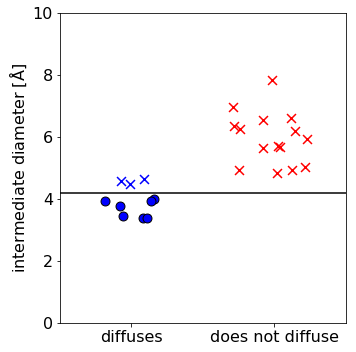

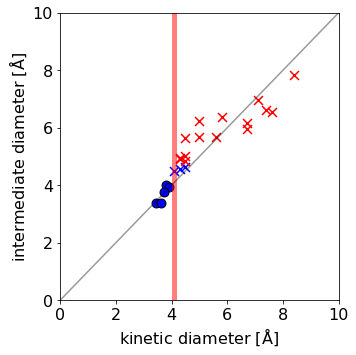

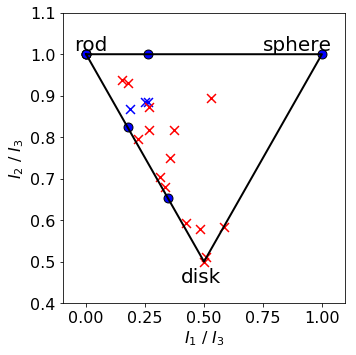

In [30]:
fig1, ax1 = plt.subplots(figsize=(5,5))
fig2, ax2 = plt.subplots(figsize=(5,5))
fig3, ax3 = plt.subplots(figsize=(5,5))
# spacing in X direction
dx = 0.15
# threshold for diffusion through ZIF-8
# from Exploring the Framework Hydrophobicity and Flexibility 
# of ZIF-8: From Biofuel Recovery to Hydrocarbon Separations
threshold = 4.2

min_diam_sums = []
mid_diam_sums = []
avg_diam_sums = []
for T in np.arange(1):
    for name, smile in molecules.items():
#         if name != 'benzene':
#             continue
        print('molecule:', name,':', 'SMILES:', smile)
        try:
            kin_diam = float(diameters[name])
        except ValueError:
            print('no radius given for this molecule - skipped')
            continue

        # Read SMILES and add Hs
        mol = Chem.AddHs(Chem.MolFromSmiles(smile))
        # 2D to 3D
        # with multiple conformers
        cids = Chem.EmbedMultipleConfs(mol, 100) #, Chem.ETKDG())
        print('No. of conformers:', len(cids))
        # quick UFF optimize
        for cid in cids: Chem.UFFOptimizeMolecule(mol, confId=cid)
        # align all conformers
        # Chem.AlignMolConformers(mol, [0])
        # show_all_conformers(v, mol, cids)
        mol_coms = get_COMs(mol)
        # get principal moments of intertia
        _, _, _, ratio_1_, ratio_2_ = get_inertial_prop(mol, cids)
        # print(np.average(ratio_1_), np.average(ratio_2_))
        conf_diameters, conf_axes, conf_moments = get_vdw_diameters(mol, cids, 
                                                                    mol_coms, 
                                                                    vdwScale=1.0, 
                                                                    boxMargin=4.0, 
                                                                    spacing=0.2,
                                                                    show=False)
        diams = [sorted(i) for i in conf_diameters]
        min_diam = np.average([i[0] for i in diams])  # use the minimum min diam
        mid_diam = np.average([i[1] for i in diams])  # use the minimum intermediate diam
        print('minimum diameter =', round(min_diam, 3), 'angstrom')
        print('intermediate diameter =', round(mid_diam, 3), 'angstrom')
        min_diam_sums.append(min_diam)
        mid_diam_sums.append(mid_diam) 
        avg_diam_sums.append(np.average([min_diam, mid_diam]))
        # for categorical plot - use the experimental results
        # get the diffusion binary result
        diffuses = df[df['molecule'] == name]['diffuse'].iloc[0]
        if diffuses == 't':
            if mid_diam <= threshold:
                C = 'b'
                M = 'o'
                E = 'k'
                D = 0.25
            else:
                C = 'b'
                M = 'x'
                E = 'k'
                D = 0.25
                print("--- lit says it diffuses, calc says it doesn't diffuse! ---")
        else:
            if mid_diam <= threshold:
                C = 'r'
                M = 'o'
                E = 'k'
                D = 0.75
                print("--- calc says it diffuses, lit says it doesn't diffuse! ---")
            else:
                C = 'r'
                M = 'x'
                E = 'k'
                D = 0.75
                # print("--- calc and lit say it doesnt diffuse! ---")
        ax1.scatter(D+(dx*(np.random.random() - 0.5) * 2),
                    mid_diam, c=C, 
                    edgecolors=E, marker=M, alpha=1.0,
                    s=80)
        ax2.scatter(kin_diam, mid_diam, c=C, 
                    edgecolors=E, marker=M, alpha=1.0,
                    s=80)
        ax3.scatter(np.average(ratio_1_), np.average(ratio_2_),
                    c=C, 
                    edgecolors=E, marker=M, alpha=1.0,
                    s=80)
    
ax1.axhline(y=threshold, c='k')
define_plot_variables(ax1,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig1.savefig("categorical.pdf", dpi=720,
            bbox_inches='tight')
fig1.tight_layout()

ax2.plot(np.linspace(-1, 12, 2), np.linspace(-1, 12, 2), c='k', alpha=0.4)
ax2.axvspan(4.0, 4.2, facecolor='r', alpha=0.5)  # plot the limit from the two Sholl papers on diffusion


define_parity_plot_variables(ax2,
                             title='',
                             xtitle='kinetic diameter [$\mathrm{\AA}$]',
                             ytitle='intermediate diameter [$\mathrm{\AA}$]',
                             xlim=(0, 10),
                             ylim=(0, 10))

fig2.savefig("parity.pdf", dpi=720,
            bbox_inches='tight')
fig2.tight_layout()

ax3.plot([0, 0.5, 1, 0], [1, 0.5, 1, 1], c='k', lw=2)
ax3.text(0.75, 1.01, 'sphere', fontsize=20)
ax3.text(0.4, 0.45, 'disk', fontsize=20)
ax3.text(-0.05, 1.01, 'rod', fontsize=20)
define_parity_plot_variables(ax3,
                             title='',
                             xtitle='$I_1$ / $I_3$',
                             ytitle='$I_2$ / $I_3$',
                             xlim=(-0.1, 1.1),
                             ylim=(0.4, 1.1))
fig3.savefig("shape.pdf", dpi=720,
            bbox_inches='tight')
fig3.tight_layout()

(0, 10)

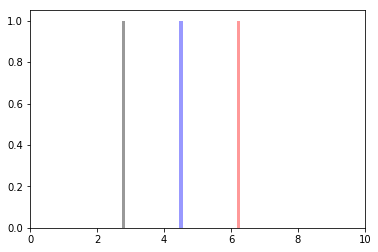

In [56]:
plt.hist(min_diam_sums, facecolor='k', alpha=0.4)
plt.hist(mid_diam_sums, facecolor='r', alpha=0.4)
plt.hist(avg_diam_sums, facecolor='b', alpha=0.4)
plt.xlim(0, 10)